In [182]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_squared_log_error

from itertools import product
import statsmodels.api as sm
import scipy
import statsmodels.tsa.api as smt
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = (10, 15)

In [157]:
# Importing data from csv files using pandas
aord = pd.read_csv('YAHOO-INDEX_AORD.csv',parse_dates=['Date'])
dji = pd.read_csv('YAHOO-INDEX_DJI.csv',parse_dates=['Date'])
gdaxi = pd.read_csv('YAHOO-INDEX_GDAXI.csv',parse_dates=['Date'])
gspc = pd.read_csv('YAHOO-INDEX_GSPC.csv',parse_dates=['Date'])


In [158]:
data = {
    "aord" : aord,
    "dji" : dji,
    "gdaxi" : gdaxi,
    "gspc" : gspc
    
}
columns_to_drop = ['Volume','Date','Adjusted Close']
y_column = 'Adjusted Close'

In [159]:
aord.groupby('Date').mean()['Close']

Date
2000-01-02    3084.500000
2000-01-03    3192.600098
2000-01-05    3071.800049
2000-01-06    3047.800049
2000-01-08    3217.800049
                 ...     
2020-12-23    6892.600098
2020-12-24    6917.500000
2020-12-29    6962.100098
2020-12-30    6942.899902
2020-12-31    6850.600098
Name: Close, Length: 5323, dtype: float64

In [160]:
aord

,Date,Open,High,Low,Close,Volume,Adjusted Close
0,2000-04-01,3152.500000,3152.500000,3122.399902,3124.100098,0.0,3124.100098
1,2000-05-01,3124.100098,3124.100098,3035.300049,3050.899902,0.0,3050.899902
2,2000-06-01,3050.899902,3075.399902,3026.000000,3030.100098,0.0,3030.100098
3,2000-07-01,3030.100098,3048.300049,3016.199951,3044.500000,0.0,3044.500000
4,2000-10-01,3044.500000,3111.500000,3044.500000,3103.100098,0.0,3103.100098
...,...,...,...,...,...,...,...
5318,2020-12-23,6845.500000,6910.700195,6845.500000,6892.600098,694790500.0,6892.600098
5319,2020-12-24,6892.600098,6953.600098,6892.600098,6917.500000,418443800.0,6917.500000
5320,2020-12-29,6917.500000,6978.799805,6917.500000,6962.100098,671628800.0,6962.100098
5321,2020-12-30,6962.100098,6962.100098,6889.500000,6942.899902,595004800.0,6942.899902


In [161]:
closingData = pd.DataFrame()
for key,value in data.items():
    closingData[key] = value.groupby('Date').mean()['Close']
    
closingData.fillna(method = 'backfill',inplace = True)

In [162]:
closingData

,aord,dji,gdaxi,gspc,hsi,n225,nya,ftse100
Date,,,,,,,,
2000-01-02,3084.500000,11041.04981,7050.459961,1409.280029,15653.86035,19423.38086,6606.890137,6290.900000
2000-01-03,3192.600098,10137.92969,7727.930176,1379.189941,16843.58984,20081.66992,6338.740234,6364.900000
2000-01-05,3071.800049,10811.78027,7272.759766,1468.250000,15519.30000,18403.08008,6878.950195,6470.500000
2000-01-06,3047.800049,10652.20020,7272.759766,1448.810059,14941.19043,16694.30078,6888.359863,6470.500000
2000-01-08,3217.800049,10606.95020,7145.529785,1438.099976,16897.44922,16099.66992,6851.350098,6379.300000
...,...,...,...,...,...,...,...,...
2020-12-23,6892.600098,30129.83008,13587.230470,3690.010010,26343.09961,26524.78906,14398.620120,6495.799805
2020-12-24,6917.500000,30199.86914,13761.379880,3703.060059,26386.56055,26668.34961,14382.500000,6502.100098
2020-12-29,6962.100098,30335.66992,13761.379880,3727.040039,26568.49023,27568.15039,14397.919920,6602.700195


In [173]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [174]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha),linewidth=1.5)
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

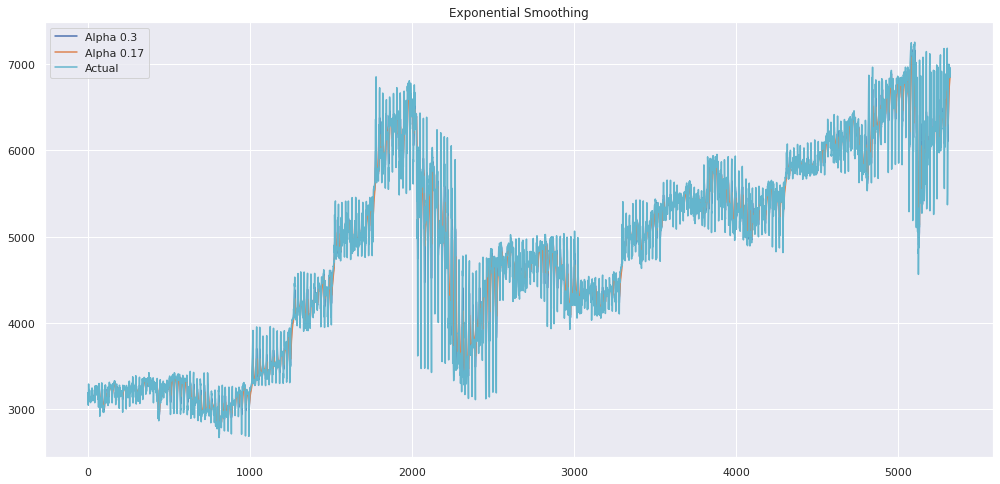

In [175]:
plot_exponential_smoothing(closingData['aord'],[0.3,0.17])